# Transfer Learning

In [1]:
import os
import torch
import torchvision
import torch.utils.data as Data
import numpy as np
import torchvision.transforms as trans
import matplotlib.pyplot as plt
import copy

print('Pytorch Version:' , torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Pytorch Version: 1.5.0


## Data Preparation using ImageFolder

In [2]:
root_dir = 'hymenoptera_data'
print('dataset structure:\n')
!tree -d hymenoptera_data

dataset structure:

hymenoptera_data
├── train
│   ├── ants
│   └── bees
└── val
    ├── ants
    └── bees

6 directories


In [3]:
# hyperparameters
BATCH_SIZE=4

data_transforms = {
    'train': trans.Compose([
        trans.RandomResizedCrop(224),
        trans.RandomHorizontalFlip(),
        trans.ToTensor(),
        # when do the transform, image pixels are compressed 
        # from (0,255) to (0,1) then we do the normalization
        trans.Normalize([0.485, 0.456, 0.406], # mean of RGB
                        [0.229, 0.224, 0.225]) # std of RGB
    ]), 
    'val': trans.Compose([
        trans.Resize(256),
        trans.CenterCrop(224),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    
}


train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=data_transforms['train']
)


val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'val'),
    transform=data_transforms['val']
)

class_names = train_data.classes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}
print('classes:', [[i, class_names[i]] for i in range(len(class_names))])
print('training data size: ', len(train_data), 'images of shape', train_data[0][0].numpy().shape)
print('validation data size: ', len(val_data), 'images of shape', val_data[0][0].numpy().shape)

classes: [[0, 'ants'], [1, 'bees']]
training data size:  244 images of shape (3, 224, 224)
validation data size:  153 images of shape (3, 224, 224)


In [4]:
# batched data
dataloaders = {  
    'train': Data.DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
#         num_workers=4
    ),

    'val': Data.DataLoader(
        dataset=val_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
#         num_workers=4
    ),    
}

We can visualize some images:

In [5]:
print('image shape: ', train_data[0][0].numpy().shape)
print('transposed image shape: ',train_data[0][0].numpy().transpose((1,2,0)).shape)

image shape:  (3, 224, 224)
transposed image shape:  (224, 224, 3)


num of images:  4
num of classes: 4


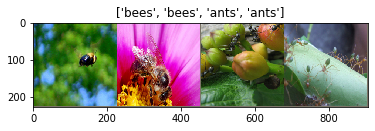

In [6]:
# denormalize and show an image 
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)

# get a batch of training data
images, classes = next(iter(dataloaders['train']))
print('num of images: ', images.size(0))
print('num of classes:', classes.size(0))

# make a grid from batch
images = torchvision.utils.make_grid(images)

imshow(images, title=[class_names[x] for x in classes])

# Train Model & Visualize Model Predictions

In [7]:
# a general function to train a model
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    """
    net: the model to be trained
    loss_fn: loss function
    scheduler: torch.optim.lr_scheduler
    """
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        step_loss = 0.0
        epoch_accuracy = 0.0
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set to training mode
            else:
                model.eval() # set to evaluate mode
            
            step_loss = 0.0
            step_corrects = 0
            
            for step, (images, labels) in enumerate(dataloaders[phase]):      
                images = images.to(device)
                labels = labels.to(device)   
                
                # forward pass, compute loss and make predictions
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                preds = torch.max(outputs, 1)[1]
                    
                # backward pass and update weights if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                # compute step loss and step corrects
                step_loss += loss.item() * images.size(0) # loss.item() extracts the loss's value
                step_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = step_loss / dataset_sizes[phase]
            epoch_accuracy = step_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            
        print()
        
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
    
    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [8]:
# generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training # if true, the model is in training mode otherwise in evaluate mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloaders['val']):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            imshow(images.cpu().data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)       

# ConvNet as fixed feature extractor

For transfer learning, we freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained:

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)

# set requires_grad == False to freeze the parameters 
# so that the gradients are not computed in backward()
for param in model_conv.parameters():
    param.requires_grad = False
    
# parameters of newly constructed modules 
# have requires_grad=True by default
n_features = model_conv.fc.in_features

# here the size of each output sample is set to 2, and it 
# can be generalized to torch.nn.Linear(n_features, len(class_names))
model_conv.fc = torch.nn.Linear(n_features, 2)

model_conv = model_conv.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

# only parameters of final layer are being optimized
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
# train and evaluate the model
model_conv = train_model(model_conv, loss_fn, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6264 Accuracy: 0.6311
val Loss: 0.2331 Accuracy: 0.9281

Epoch 1/24
----------
train Loss: 0.4394 Accuracy: 0.7787
val Loss: 0.2029 Accuracy: 0.9281

Epoch 2/24
----------
train Loss: 0.5948 Accuracy: 0.7377
val Loss: 0.2093 Accuracy: 0.9281

Epoch 3/24
----------
train Loss: 0.4228 Accuracy: 0.8115
val Loss: 0.1940 Accuracy: 0.9412

Epoch 4/24
----------
train Loss: 0.4055 Accuracy: 0.8443
val Loss: 0.2086 Accuracy: 0.9346

Epoch 5/24
----------
train Loss: 0.4592 Accuracy: 0.7910
val Loss: 0.2428 Accuracy: 0.9150

Epoch 6/24
----------
train Loss: 0.7577 Accuracy: 0.7418
val Loss: 0.2075 Accuracy: 0.9412

Epoch 7/24
----------
train Loss: 0.3140 Accuracy: 0.8525
val Loss: 0.2318 Accuracy: 0.9216

Epoch 8/24
----------
train Loss: 0.3182 Accuracy: 0.8607
val Loss: 0.2136 Accuracy: 0.9346

Epoch 9/24
----------
train Loss: 0.3306 Accuracy: 0.8525
val Loss: 0.1932 Accuracy: 0.9346

Epoch 10/24
----------
train Loss: 0.3322 Accuracy: 0.8607
val Loss: 0

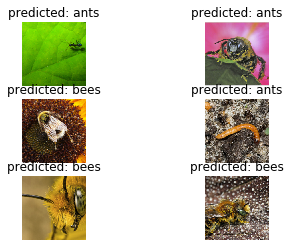

In [11]:
visualize_model(model_conv)

## Reference

[transfer learning for computer vision tutorial]`https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)`